# Customer Segmentation & Demand Patterns

Objective
Segment customers based on purchasing behavior and detect demand trends.
Tasks

●	Segment customers into high-value, frequent, and occasional buyers using K-Means clustering.

●	Analyze sales trends to identify peak ordering periods.

●	Visualize customer segments and order patterns using graphs.


## Import Important libraries

In [297]:
# installing required liberies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from datetime import datetime


In [298]:
import warnings
warnings.filterwarnings('ignore')

## Load & Explore Customer Data

In [300]:
# Load the Customers dataset
customers_df = pd.read_csv("Customers.csv")

# Convert last_order_date to datetime format
customers_df['last_order_date'] = pd.to_datetime(customers_df['last_order_date'])

# Calculate Recency (days since last purchase)
latest_date = customers_df['last_order_date'].max()
customers_df['recency'] = (latest_date - customers_df['last_order_date']).dt.days

# Select relevant features for clustering
customer_data = customers_df[['total_spend', 'num_orders', 'recency']]

# Display first few rows
print(customer_data.head())


   total_spend  num_orders  recency
0  8072.510788          14      217
1  4295.331083          39      116
2  9527.625896          10      235
3  4760.739090          46      300
4  6070.383831          45      190


## Normalize the Data for Clustering

In [302]:
scaler = StandardScaler()
customer_scaled = scaler.fit_transform(customer_data)


## Find Optimal Number of Clusters Using the Elbow Method

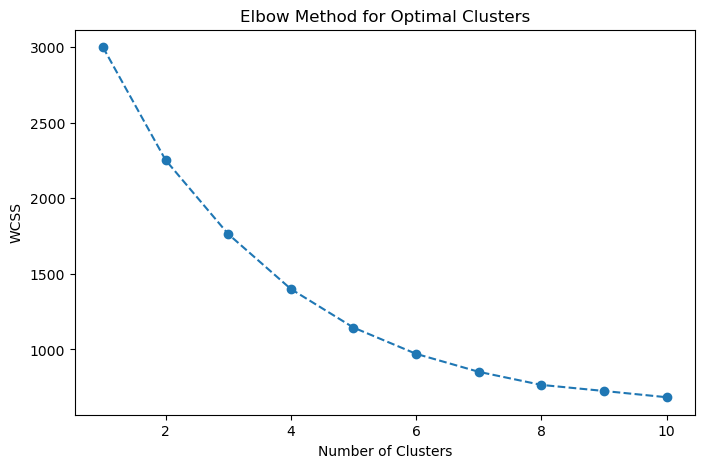

In [304]:
# Determine the optimal number of clusters
wcss = []  # Within-cluster sum of squares

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(customer_scaled)
    wcss.append(kmeans.inertia_)  # Inertia is the sum of squared distances

# Plot Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal Clusters')
plt.show()


## Apply K-Means Clustering

In [306]:
# Apply K-Means with the chosen number of clusters (e.g., 3)
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
customers_df['Cluster'] = kmeans.fit_predict(customer_scaled)


## Analyze & Label Customer Segments

In [308]:
# Rename clusters meaningfully based on avg values
cluster_summary = customers_df.groupby('Cluster')[['total_spend', 'num_orders', 'recency']].mean().reset_index()
print("\nCluster Summary:\n", cluster_summary)

# Assign labels based on characteristics
cluster_labels = { 
    cluster_summary.sort_values('total_spend', ascending=False).iloc[0]['Cluster']: "High-Value Buyers",
    cluster_summary.sort_values('num_orders', ascending=False).iloc[1]['Cluster']: "Frequent Buyers",
    cluster_summary.sort_values('recency', ascending=True).iloc[2]['Cluster']: "Occasional Buyers"
}

# Map labels
customers_df['Segment'] = customers_df['Cluster'].map(cluster_labels)



Cluster Summary:
    Cluster  total_spend  num_orders     recency
0        0  5491.731677   37.409894  263.802120
1        1  5524.025590   11.315493  212.261972
2        2  4412.616928   31.035912   80.674033


## Visualize Clusters

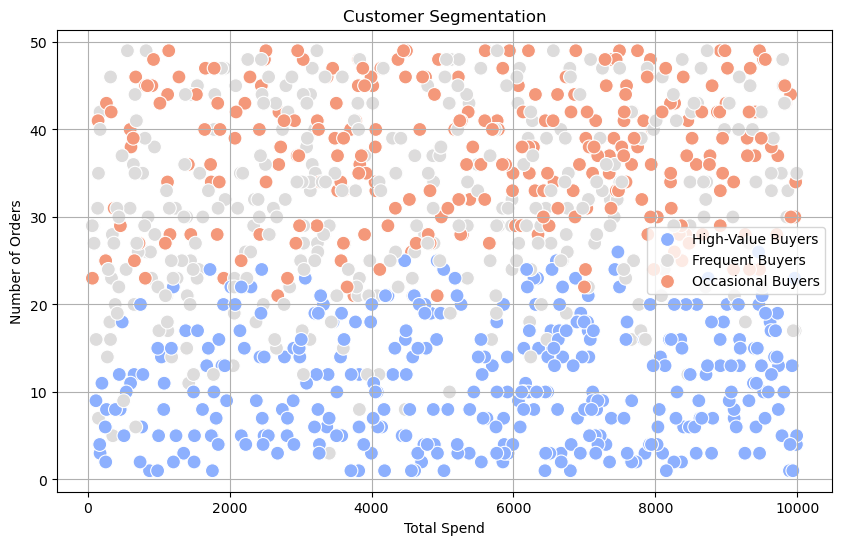

In [310]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=customers_df, x='total_spend', y='num_orders', hue='Segment', palette='coolwarm', s=100)
plt.xlabel("Total Spend")
plt.ylabel("Number of Orders")
plt.title("Customer Segmentation")
plt.legend()
plt.grid()
plt.show()

## Load Sales Data & Convert Dates

In [312]:
# Load the Sales dataset
sales_df = pd.read_csv("Sales_data.csv")

# Convert order_date to datetime format
sales_df['order_date'] = pd.to_datetime(sales_df['order_date'])

# Extract useful time features
sales_df['year'] = sales_df['order_date'].dt.year
sales_df['month'] = sales_df['order_date'].dt.month
sales_df['day_of_week'] = sales_df['order_date'].dt.day_name()
sales_df['hour'] = sales_df['order_date'].dt.hour  # Works if timestamp is available

## Monthly Sales Trend Analysis

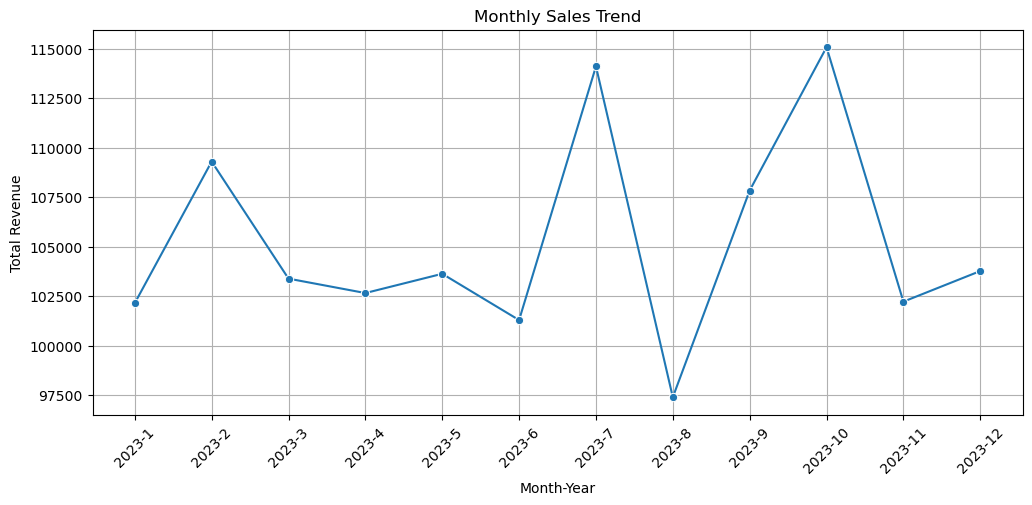

In [314]:
# Aggregate revenue by month
monthly_sales = sales_df.groupby(['year', 'month'])['revenue'].sum().reset_index()

# Create a month-year column for better visualization
monthly_sales['month_year'] = monthly_sales['year'].astype(str) + '-' + monthly_sales['month'].astype(str)

# Plot monthly sales trend
plt.figure(figsize=(12, 5))
sns.lineplot(data=monthly_sales, x='month_year', y='revenue', marker='o')
plt.xticks(rotation=45)
plt.xlabel("Month-Year")
plt.ylabel("Total Revenue")
plt.title("Monthly Sales Trend")
plt.grid()
plt.show()


## Sales by Day of the Week

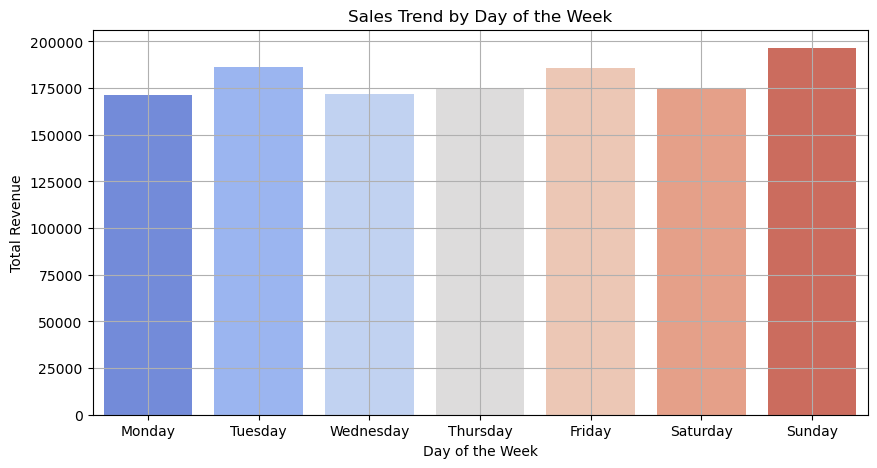

In [316]:
# Aggregate revenue by weekday
weekday_sales = sales_df.groupby('day_of_week')['revenue'].sum().reset_index()

# Order days correctly
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_sales['day_of_week'] = pd.Categorical(weekday_sales['day_of_week'], categories=weekday_order, ordered=True)

# Plot sales by weekday
plt.figure(figsize=(10, 5))
sns.barplot(data=weekday_sales, x='day_of_week', y='revenue', palette='coolwarm')
plt.xlabel("Day of the Week")
plt.ylabel("Total Revenue")
plt.title("Sales Trend by Day of the Week")
plt.grid()
plt.show()


## Hourly Sales Trend

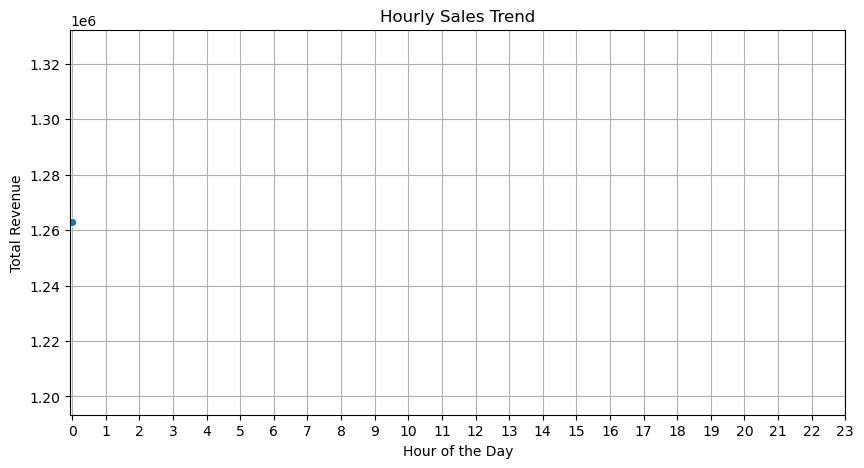

In [318]:
# Aggregate revenue by hour
hourly_sales = sales_df.groupby('hour')['revenue'].sum().reset_index()

# Plot hourly sales trend
plt.figure(figsize=(10, 5))
sns.lineplot(data=hourly_sales, x='hour', y='revenue', marker='o')
plt.xticks(range(0, 24))
plt.xlabel("Hour of the Day")
plt.ylabel("Total Revenue")
plt.title("Hourly Sales Trend")
plt.grid()
plt.show()


## Rolling Averages for Trend Smoothing

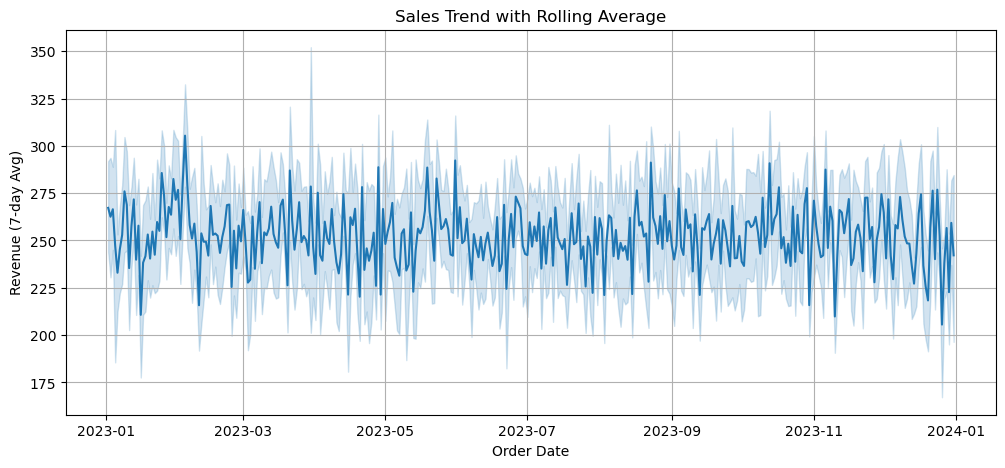

In [320]:
# Compute rolling 7-day average for revenue trends
sales_df['rolling_avg'] = sales_df['revenue'].rolling(window=7).mean()

# Plot rolling average trend
plt.figure(figsize=(12, 5))
sns.lineplot(x=sales_df['order_date'], y=sales_df['rolling_avg'])
plt.xlabel("Order Date")
plt.ylabel("Revenue (7-day Avg)")
plt.title("Sales Trend with Rolling Average")
plt.grid()
plt.show()


## Detect Seasonal Patterns Using Boxplot

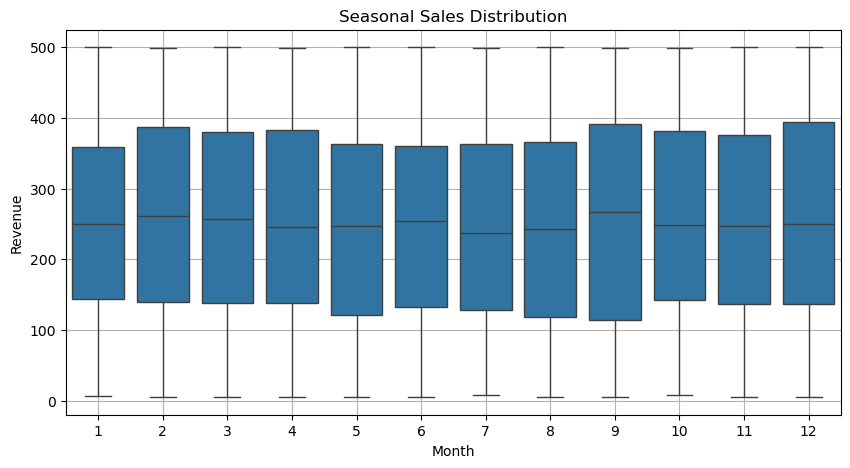

In [322]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=sales_df, x='month', y='revenue')
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.title("Seasonal Sales Distribution")
plt.grid()
plt.show()


## Scatter Plot for Customer Segments (Spend vs. Orders)

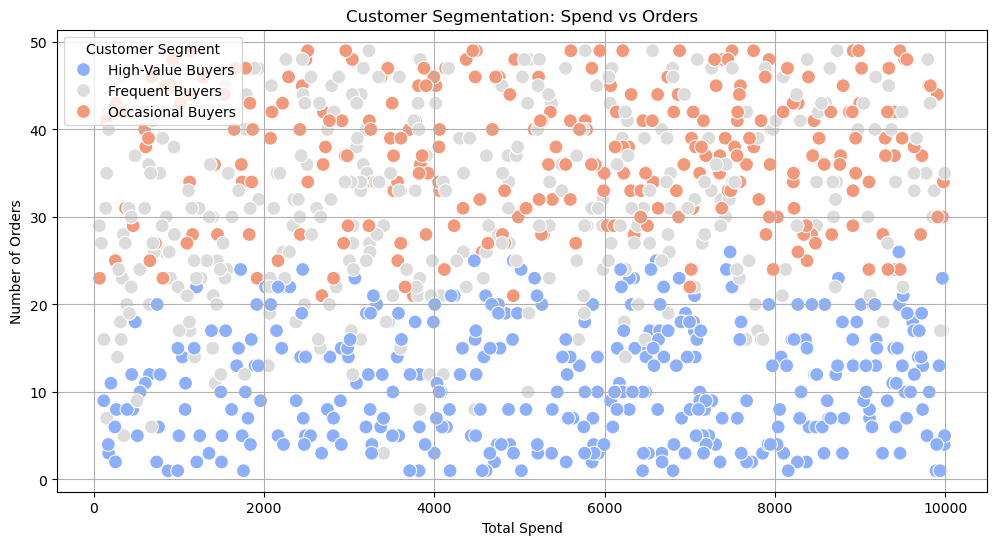

In [324]:
# Scatter plot of customer segments
plt.figure(figsize=(12, 6))
sns.scatterplot(data=customers_df, x='total_spend', y='num_orders', hue='Segment', palette='coolwarm', s=100)
plt.title("Customer Segmentation: Spend vs Orders")
plt.xlabel("Total Spend")
plt.ylabel("Number of Orders")
plt.legend(title="Customer Segment")
plt.grid(True)
plt.show()

## Bar Plot of Average Spend by Segment

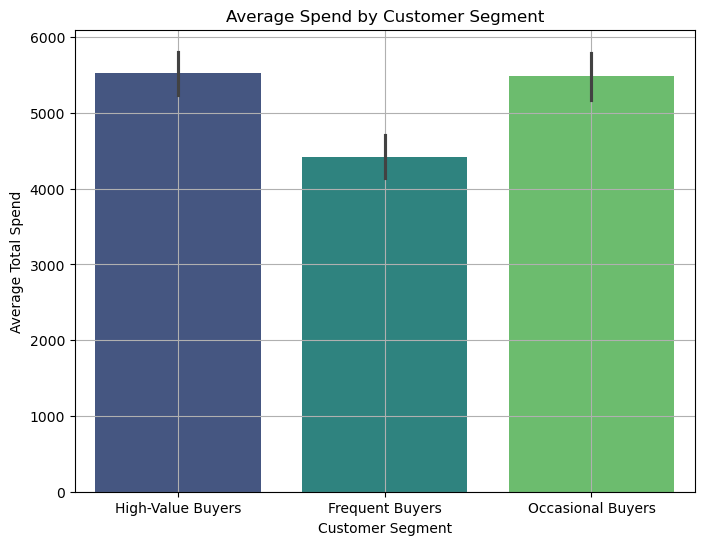

In [326]:
# Bar plot of average spend by segment
plt.figure(figsize=(8, 6))
sns.barplot(data=customers_df, x='Segment', y='total_spend', palette='viridis')
plt.title("Average Spend by Customer Segment")
plt.xlabel("Customer Segment")
plt.ylabel("Average Total Spend")
plt.grid(True)
plt.show()


# Business Case Study: Discount Impact Analysis

## Load the Data

In [329]:
import pandas as pd

# Load the discount_campaign dataset
discount_campaign_df = pd.read_csv("discount_campaign.csv")

# Check the first few rows to understand the structure
print(discount_campaign_df.head())


   customer_id discount_applied  order_count_before  order_count_after  \
0         1286               No                   4                 11   
1         1563              Yes                  10                  2   
2         1289               No                   2                  8   
3         1053               No                   4                  3   
4         1516              Yes                  19                  2   

   total_spend_before  total_spend_after  
0         1736.119038        3601.461583  
1          923.649992         387.822968  
2         3526.359734        9705.813801  
3         1683.084961         326.592907  
4         3746.981815        6747.656727  


## Compare Spending Behavior Before and After Discount

In [331]:
# Calculate the change in spending before and after the discount
discount_campaign_df['spend_difference'] = discount_campaign_df['total_spend_after'] - discount_campaign_df['total_spend_before']

# Display the updated dataframe
print(discount_campaign_df[['customer_id', 'total_spend_before', 'total_spend_after', 'spend_difference']].head())


   customer_id  total_spend_before  total_spend_after  spend_difference
0         1286         1736.119038        3601.461583       1865.342545
1         1563          923.649992         387.822968       -535.827024
2         1289         3526.359734        9705.813801       6179.454067
3         1053         1683.084961         326.592907      -1356.492055
4         1516         3746.981815        6747.656727       3000.674912


## Visualize the Spending Difference

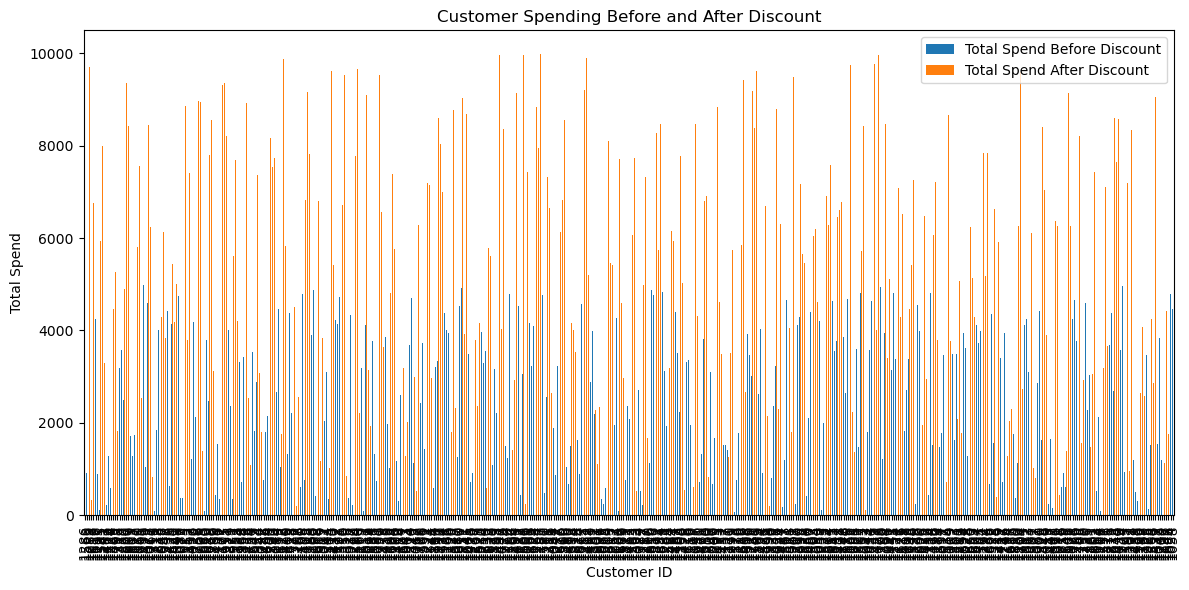

In [333]:
import matplotlib.pyplot as plt

# Bar plot for total spend before and after the discount
discount_campaign_df[['total_spend_before', 'total_spend_after']].plot(kind='bar', figsize=(12, 6))

plt.title("Customer Spending Before and After Discount")
plt.xlabel("Customer ID")
plt.ylabel("Total Spend")
plt.xticks(range(len(discount_campaign_df)), discount_campaign_df['customer_id'], rotation=90)
plt.legend(['Total Spend Before Discount', 'Total Spend After Discount'])
plt.tight_layout()
plt.show()


## Statistical Analysis:

In [335]:
from scipy import stats

# Perform paired t-test to compare total spend before and after the discount
t_stat, p_value = stats.ttest_rel(discount_campaign_df['total_spend_before'], discount_campaign_df['total_spend_after'])

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")


T-statistic: -18.562123207985827
P-value: 7.194118379469438e-59


## Additional Analysis:

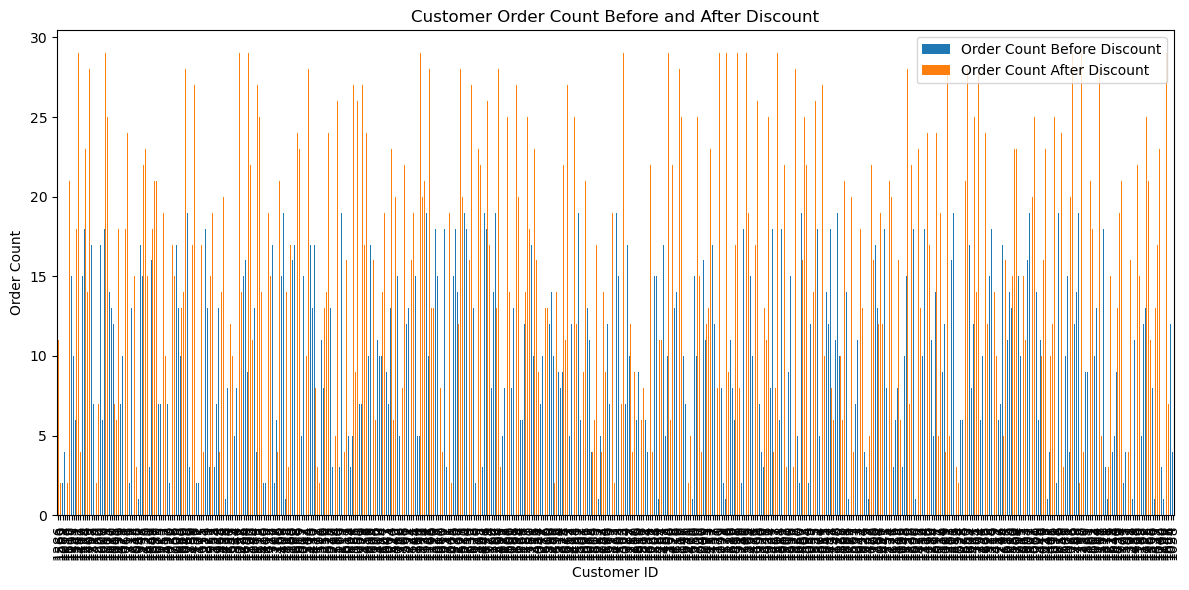

In [337]:
# Calculate the difference in order count before and after the discount
discount_campaign_df['order_count_difference'] = discount_campaign_df['order_count_after'] - discount_campaign_df['order_count_before']

# Visualize the change in order count
discount_campaign_df[['order_count_before', 'order_count_after']].plot(kind='bar', figsize=(12, 6))

plt.title("Customer Order Count Before and After Discount")
plt.xlabel("Customer ID")
plt.ylabel("Order Count")
plt.xticks(range(len(discount_campaign_df)), discount_campaign_df['customer_id'], rotation=90)
plt.legend(['Order Count Before Discount', 'Order Count After Discount'])
plt.tight_layout()
plt.show()
